# Exploring Co‑Benefit and Respiratory Health Data for Scotland’s NHS Boards

This notebook documents the data exploration and processing steps used to prepare the inputs for my DataLabs Data Visualisation Contest 2025 submission. The goal of this analysis is to understand how environmental co‑benefits such as: improved air quality, reduced dampness, and warmer homes translate into projected monetary savings related to respiratory health across Scotland’s NHS Boards.

## Purpose
- To import, explore, clean, and prepare the **Co‑Benefit Atlas (Level 3)** data for use in a temporal map visualisation created in QGIS.
- To explore and clean **respiratory illness case data** for contextual analysis (not used directly in the final visualisation, but included as supporting exploratory work).
- To generate aggregated values at the **NHS Board level** that represent the yearly projected monetary benefit of selected co‑benefit/damage pathways.

## Overview of the Process
1. **Load datasets:**  
   - Co‑Benefit Atlas data (Level 3)  
   - Lookup tables and provided boundary files  
   - Weekly respiratory illness data (COVID‑19, Influenza, RSV) from Open Data Scotland  

2. **Clean and prepare data:**  
   - Standardise names, filter fields, remove duplicates
   - Handle missing or inconsistent values
   - Select five key co‑benefit pathways related to respiratory health  

3. **Calculate per‑board values:**  
   - Multiply yearly projected benefit by Data Zone population  
   - Aggregate results to NHS Board level  
   - Export cleaned/aggregated files for use in QGIS  

4. **Explore respiratory illness cases:**  
   - Summarise trends from 2017–2025  
   - Examine variation between NHS Boards  
   - (Further visualisations may be added later)

## Outputs
- Cleaned and structured datasets ready for QGIS  
- Aggregated NHS Board–level tables of projected monetary value  
- Optional exploratory summaries of respiratory illness patterns  
- Reproducible workflow for future extensions of the visualisation

This notebook provides the analytical foundation for the spatial‑temporal map featured as my contest submission.

# Content

**[Imports and constants](#imports_and_constants)**    
- [Imports](#imports)
- [Constants](#constants)  

**[Exploring the data](#exploring)**  

 - [Co-benefit atlas data](#exploring_atlas)
 - [Respiratory data](#exploring_respiratory)
 - [Other data](#exploring_other_data)

**[Cleaning and reshaping the data](#cleaning)**
 - [Clean and reshape the atlas data](#cleaning_atlas)
 - [Clean and reshape the flu data](#cleaning_respiratory)

**[Merging the data](#merging)**


**[Analysis and visualisations](#analysis)**



## <a id=imports_and_constants></a>Imports and constants

### <a id=imports></a>Imports

In [57]:
# libraries
import pandas as pd
import numpy as np

import matplotlib as plt
import seaborn as sns
import plotly.express as px

sns.set_theme(style="darkgrid", palette="bright", rc={"figure.figsize": (20, 14)})

### <a id=constants></a>Constants

In [2]:
ATLAS_DATA = 'data/Level_3.xlsx'
LOOKUP_DATA = 'data/lookups/lookups.xlsx'
RESPIRATORY_DATA = 'data/Weekly_Cases_for_COVID-19_Influenza_and_RSV_by_Health_Board_10-01-2026.csv'
ZONE_DATA = 'data/Data_Zone_2011.csv'
BOUNDARY_DATA = 'data/scottish_local_authority_boundaries_-1688973826847610659.csv'
NHS_BOUNDARY_DATA = 'data/Healthcare_NHS_Health_Boards__Scotland__-1967510779717308092.csv'

## <a id=exploring></a>Exploring the data

### <a id=exploring_atlas></a>Exploring the co-benefit atlas data

For the co-benefit atlas data, I am mainly interested in exploring the co-benefits and damage pathways that may possibly relate to respiratory health.
I decided to explore:<br> Co-benefits: air quality, dampness, and excess cold<br>
Damage pathways: reduced mortality, NHS, and quality-qdjusted life year (QALY)

In [3]:
# read level 3 co-benefit atlas data into memory
atlas_df3 = pd.read_excel(ATLAS_DATA)

In [ ]:
atlas_df3.info()

In [ ]:
atlas_df3.describe()

In [9]:
atlas_df3.head()

,small_area,co-benefit_type,damage_pathway,damage_type,2025,2026,2027,2028,2029,2030,...,2042,2043,2044,2045,2046,2047,2048,2049,2050,sum
0,E01000001,air_quality,reduced_mortality,health,0.003336,0.003663,6.917033e-03,8.674610e-03,1.085301e-02,1.408742e-02,...,6.968484e-02,7.270200e-02,7.526418e-02,7.737418e-02,7.860485e-02,7.868850e-02,7.817872e-02,7.763434e-02,7.710436e-02,1.201945
1,E01000001,air_quality,society,non-health,0.000039,0.000043,8.140000e-05,1.020450e-04,1.276710e-04,1.657200e-04,...,8.197480e-04,8.552410e-04,8.853820e-04,9.102030e-04,9.246800e-04,9.256640e-04,9.196670e-04,9.132640e-04,9.070290e-04,0.014139
2,E01000001,congestion,time_saved,non-health,0.005570,0.009543,1.191381e-02,1.324733e-02,1.365541e-02,1.479793e-02,...,-2.996094e-02,-3.209987e-02,-3.437791e-02,-3.693888e-02,-4.099173e-02,-4.281875e-02,-4.471182e-02,-4.611941e-02,-4.897514e-02,-0.369011
3,E01000001,dampness,NHS,non-health,0.000000,0.000000,1.260000e-05,1.240000e-05,1.240000e-05,2.410000e-06,...,2.970000e-05,3.320000e-05,3.290000e-05,3.200000e-05,3.180000e-05,3.150000e-05,3.150000e-05,3.130000e-05,3.110000e-05,0.000504
4,E01000001,dampness,QALY,health,0.000000,0.000000,3.070000e-07,3.050000e-07,3.030000e-07,5.910000e-08,...,7.260000e-07,8.120000e-07,8.060000e-07,7.830000e-07,7.780000e-07,7.720000e-07,7.710000e-07,7.650000e-07,7.610000e-07,0.000012


In [10]:
# check for null values in df
atlas_df3[atlas_df3.isnull().any(axis=1)]

,small_area,co-benefit_type,damage_pathway,damage_type,2025,2026,2027,2028,2029,2030,...,2042,2043,2044,2045,2046,2047,2048,2049,2050,sum
824673,S01010206,hassle_costs,time_saved,non-health,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
825073,S01010226,hassle_costs,time_saved,non-health,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
825093,S01010227,hassle_costs,time_saved,non-health,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [19]:
atlas_df3['damage_pathway'].unique()

array(['reduced_mortality', 'society', 'time_saved', 'NHS', 'QALY',
       'amenity', 'sleep_disturbance'], dtype=object)

### <a id=exploring_respiratory></a>Exploring the respiratory illness data


In [11]:
# dataset containing weekly cases for COVID-19, influenza, and RSV by health board
respiratory_df = pd.read_csv(RESPIRATORY_DATA,
                     usecols=['ISOyear', 'HBName', 'HBcode', 
                              'Pathogen', 'NumberCasesPerWeek', 'RateCasesPerWeek', 'Population', 
                              'WeekBeginning', 'WeekEnding'])

In [12]:
respiratory_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33569 entries, 0 to 33568
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ISOyear             33569 non-null  int64  
 1   WeekBeginning       33569 non-null  int64  
 2   WeekEnding          33569 non-null  int64  
 3   Pathogen            33569 non-null  object 
 4   HBcode              33569 non-null  object 
 5   HBName              33569 non-null  object 
 6   NumberCasesPerWeek  33569 non-null  int64  
 7   RateCasesPerWeek    33569 non-null  float64
 8   Population          33569 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 2.3+ MB


In [13]:
respiratory_df.head(2)

,ISOyear,WeekBeginning,WeekEnding,Pathogen,HBcode,HBName,NumberCasesPerWeek,RateCasesPerWeek,Population
0,2016,20161003,20161009,Influenza (All),S08000015,NHS Ayrshire and Arran,0,0.0,369730
1,2016,20161003,20161009,Influenza (All),S08000016,NHS Borders,1,0.9,115460


In [14]:
respiratory_df['HBName'].unique()

array(['NHS Ayrshire and Arran', 'NHS Borders',
       'NHS Dumfries and Galloway', 'NHS Forth Valley', 'NHS Grampian',
       'NHS Highland', 'NHS Lothian', 'NHS Orkney', 'NHS Shetland',
       'NHS Western Isles', 'NHS Fife', 'NHS Tayside',
       'NHS Greater Glasgow and Clyde', 'NHS Lanarkshire', 'Scotland'],
      dtype=object)

In [15]:
respiratory_df['Pathogen'].unique()

array(['Influenza (All)', 'Influenza A', 'Influenza B', 'RSV', 'COVID-19'],
      dtype=object)

### <a id=exploring_other_data></a>Exploring other data

This data will be used to create mappings between data zones, local authourities, and NHS health boards to enable joins and visualisations.

In [14]:
# lookup data to combone with main atlas data
lookup_df = pd.read_excel(LOOKUP_DATA, 
                          usecols=['small_area', 'population', 'households', 'local_authority', 'nation'])

In [ ]:
lookup_df.head(2)

In [ ]:
lookup_df.info()

In [4]:
lookup_df['nation'].unique()

array(['Eng/Wales', 'NI', 'Scotland'], dtype=object)

In [15]:
# data zone data containing health board, local authority, and small area info and drop duplicate rows
zone_df = pd.read_csv(ZONE_DATA, 
                      usecols=['HB','CAName', 'HBName', 'DataZone']).rename(columns={'DataZone': 'small_area'})

In [7]:
zone_df.head(2)

,small_area,CAName,HB,HBName
0,S01006506,Aberdeen City,S08000020,NHS Grampian
1,S01006507,Aberdeen City,S08000020,NHS Grampian


In [34]:
zone_df['HBName'].unique()

array(['NHS Grampian', 'NHS Tayside', 'NHS Highland', 'NHS Forth Valley',
       'NHS Dumfries and Galloway', 'NHS Ayrshire and Arran',
       'NHS Greater Glasgow and Clyde', 'NHS Lothian',
       'NHS Western Isles', 'NHS Fife', 'NHS Lanarkshire', 'NHS Orkney',
       'NHS Borders', 'NHS Shetland'], dtype=object)

In [13]:
# boundary data to compare local authourity names for consistency
boundary_df = pd.read_csv(BOUNDARY_DATA)

In [39]:
boundary_df.head(2)

,OBJECTID,local_auth,code,hectares,Shape__Area,Shape__Length
0,1,Clackmannanshire,S12000005,16391.26,1.639126e+08,83968.802476
1,2,Dundee City,S12000042,6222.38,6.222375e+07,54000.756203


In [14]:
# see if there are any la names that don't match between datasets
a = sorted(zone_df['CAName'].unique())
b = sorted(boundary_df['local_auth'].unique())

c = list(set(a) - set(b))
print(c)

['Na h-Eileanan Siar']


In [15]:
nhs_boundary_df = pd.read_csv(NHS_BOUNDARY_DATA)

In [16]:
nhs_boundary_df.head(2)

,OBJECTID_1,gml_id,h06_code,h06_name,h06_se_cod,Shape__Area,Shape__Length
0,1,NHS_Areas_363.1,11,Ayrshire & Arran,S08000001,3.405385e+09,614862.255672
1,2,NHS_Areas_363.2,6,Borders,S08000002,4.695046e+09,498252.120207


In [41]:
nhs_boundary_df['h06_name'].unique()

array(['Ayrshire & Arran', 'Borders', 'Dumfries & Galloway', 'Fife',
       'Forth Valley', 'Grampian', 'Greater Glasgow & Clyde', 'Highland',
       'Lanarkshire', 'Lothian', 'Orkney', 'Shetland', 'Tayside',
       'Western Isles'], dtype=object)

## <a id=cleaning></a>Cleaning and reshaping the data

### <a id=cleaning_atlas></a>Cleaning and reshaping the co-benefit atlas data

In [5]:
# drop rows with NULL values
atlas_df3 = atlas_df3.dropna()

In [6]:
# keep only Scotland data
atlas_scot_df = atlas_df3[atlas_df3['small_area'].astype(str).str.startswith('S01')].copy()

In [7]:
# drop sum column before reshaping
atlas_scot_df = atlas_scot_df.drop(columns=['sum'])

In [8]:
# damage pathways for exploration related to health, quality of life, and the NHS
damage_pathways = ['NHS', 'reduced_mortality', 'QALY']

# co benefits possibly related to respiratory illness: 
# air quality=air circulation can increase spread, excess cold=reduced immune response, dampness=humidity can aid virus transmission
co_benefit_type = ['air_quality', 'excess_cold', 'dampness']

In [9]:
# filter on the relevant co benefits and damage pathways
atlas_scot_df = atlas_scot_df[atlas_scot_df['co-benefit_type'].isin(co_benefit_type) &
                              atlas_scot_df['damage_pathway'].isin(damage_pathways)].copy()

In [10]:
# convert from wide into long form

# vars for id and values
year_cols = [y for y in range (2025, 2051)]
id_cols = ['small_area', 'co-benefit_type', 'damage_pathway', 'damage_type']

# reshape into long form for time-series analysis
atlas_scot_df = atlas_scot_df.melt(
    id_vars=id_cols,
    value_vars=year_cols,
    var_name='year',
    value_name='co_benefit_value'
)

In [11]:
# check that the data is in the intended form
atlas_scot_df.head()

,small_area,co-benefit_type,damage_pathway,damage_type,year,co_benefit_value
0,S01006506,air_quality,reduced_mortality,health,2025,0.001573
1,S01006506,dampness,NHS,non-health,2025,0.000000
2,S01006506,dampness,QALY,health,2025,0.000000
3,S01006506,excess_cold,NHS,non-health,2025,0.000000
4,S01006506,excess_cold,QALY,health,2025,0.000000


### <a id=cleaning_respiratory></a>Cleaning and reshaping the respiratory illness data

In [16]:
# pathogen data to keep
pathogens = ['Influenza (All)', 'RSV', 'COVID-19']
years = [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]

In [17]:
respiratory_df = respiratory_df[(respiratory_df['Pathogen'].isin(pathogens)) &
                                (respiratory_df['ISOyear'].isin(years)) &
                                (respiratory_df['HBName'] != 'Scotland')].copy().reset_index(drop=True) # keep only influenza data drop rows where HBName equals 'Scotland' 
                                                                                                        # as this is a total count of flu cases in Scotland each week

In [23]:
respiratory_df.head(10)

,ISOyear,WeekBeginning,WeekEnding,Pathogen,HBcode,HBName,NumberCasesPerWeek,RateCasesPerWeek,Population
0,2017,2017-01-02,2017-01-08,Influenza (All),S08000015,NHS Ayrshire and Arran,20,5.4,369730
1,2017,2017-01-02,2017-01-08,Influenza (All),S08000016,NHS Borders,15,13.0,115460
2,2017,2017-01-02,2017-01-08,Influenza (All),S08000017,NHS Dumfries and Galloway,23,15.5,148390
3,2017,2017-01-02,2017-01-08,Influenza (All),S08000019,NHS Forth Valley,11,3.6,301800
4,2017,2017-01-02,2017-01-08,Influenza (All),S08000020,NHS Grampian,21,3.6,583910
5,2017,2017-01-02,2017-01-08,Influenza (All),S08000022,NHS Highland,23,7.1,322800
6,2017,2017-01-02,2017-01-08,Influenza (All),S08000024,NHS Lothian,100,11.5,869170
7,2017,2017-01-02,2017-01-08,Influenza (All),S08000025,NHS Orkney,1,4.6,21640
8,2017,2017-01-02,2017-01-08,Influenza (All),S08000026,NHS Shetland,0,0.0,23240
9,2017,2017-01-02,2017-01-08,Influenza (All),S08000028,NHS Western Isles,1,3.7,26700


In [20]:
# convert 'WeekBeginning' and 'WeekEnding' columns to date
respiratory_df['WeekBeginning'] = pd.to_datetime(respiratory_df['WeekBeginning'], format='%Y%m%d')
respiratory_df['WeekEnding'] = pd.to_datetime(respiratory_df['WeekEnding'], format='%Y%m%d')

In [199]:
# group the data by year and healthboard
respiratory_hb_df =  respiratory_df.groupby(['ISOyear', 'HBcode', 'HBName', 'Pathogen'], 
                            as_index=False).agg(total_cases=('NumberCasesPerWeek', 'sum'), population=('Population', 'max'))

In [200]:
respiratory_hb_df.head()

,ISOyear,HBcode,HBName,Pathogen,total_cases,population
0,2017,S08000015,NHS Ayrshire and Arran,Influenza (All),370,369730
1,2017,S08000015,NHS Ayrshire and Arran,RSV,174,369730
2,2017,S08000016,NHS Borders,Influenza (All),290,115970
3,2017,S08000016,NHS Borders,RSV,79,115970
4,2017,S08000017,NHS Dumfries and Galloway,Influenza (All),264,148390


### <a id=cleaning_other></a>Cleaning and reshaping other data

In [73]:
# only keep data where region equals Scotland
lookup_df = lookup_df[lookup_df['nation'] == 'Scotland'].copy()

In [153]:
# only match for hb codes
zone_hb_df = zone_df[['HB', 'h06_se_cod']].drop_duplicates(subset=['HB'])

## <a id=merging></a>Merging and agregating the data

In [16]:
# dict to map to hb codes in nhs boundary shapefile
name_to_h06 = {
    "NHS Ayrshire and Arran": "S08000001",
    "NHS Borders": "S08000002",
    "NHS Dumfries and Galloway": "S08000003",
    "NHS Fife": "S08000004",
    "NHS Forth Valley": "S08000005",
    "NHS Grampian": "S08000006",
    "NHS Greater Glasgow and Clyde": "S08000007",
    "NHS Highland": "S08000008",
    "NHS Lanarkshire": "S08000009",
    "NHS Lothian": "S08000010",
    "NHS Orkney": "S08000011",
    "NHS Shetland": "S08000012",
    "NHS Tayside": "S08000013",
    "NHS Western Isles": "S08000014",
}

In [17]:
zone_df["h06_se_cod"] = zone_df["HBName"].map(name_to_h06)

In [18]:
zone_df.head()

,small_area,CAName,HB,HBName,h06_se_cod
0,S01006506,Aberdeen City,S08000020,NHS Grampian,S08000006
1,S01006507,Aberdeen City,S08000020,NHS Grampian,S08000006
2,S01006508,Aberdeen City,S08000020,NHS Grampian,S08000006
3,S01006509,Aberdeen City,S08000020,NHS Grampian,S08000006
4,S01006510,Aberdeen City,S08000020,NHS Grampian,S08000006


In [20]:
atlas_scot_df['small_area'].nunique()

6976

In [27]:
atlas_qgis_df['small_area'].nunique()

6976

In [21]:
# combine atlas data with lookup
atlas_combined_df = atlas_scot_df.merge(lookup_df[['small_area', 'population', 'local_authority']], 
                                  how='left', 
                                  on='small_area')

In [22]:
# add column with total calculated benefit using co_benefit_Value * population for each small area
atlas_combined_df['total_co_benefit_value'] = atlas_combined_df.apply(lambda row: row.co_benefit_value * row.population, axis=1)

In [23]:
atlas_combined_df.tail()

,small_area,co-benefit_type,damage_pathway,damage_type,year,co_benefit_value,population,local_authority,total_co_benefit_value
906875,S01013481,air_quality,reduced_mortality,health,2050,0.041743,923,West Lothian,38.528742
906876,S01013481,dampness,NHS,non-health,2050,0.000139,923,West Lothian,0.128257
906877,S01013481,dampness,QALY,health,2050,0.000003,923,West Lothian,0.003138
906878,S01013481,excess_cold,NHS,non-health,2050,0.000481,923,West Lothian,0.444135
906879,S01013481,excess_cold,QALY,health,2050,0.004799,923,West Lothian,4.429655


In [24]:
# for temporal mapping in qgis, I want to visualise the total cost of all 5 pairs of co-benefit/pathways values of interest
atlas_qgis_df = atlas_combined_df.groupby(['small_area', 'year'], as_index=False).agg(total_benefit=('total_co_benefit_value', 'sum'))

In [26]:
# combine with zone data
atlas_qgis_df = atlas_qgis_df.merge(zone_df[['small_area', 'h06_se_cod', 'HBName', 'CAName']], 
                                            how='left', 
                                            on='small_area').rename(columns={'CAName': 'Local Authority', 'HBName': 'NHS Board'})

In [28]:
atlas_qgis_df.head()

,small_area,year,total_benefit,h06_se_cod,NHS Board,Local Authority
0,S01006506,2025,1.357863,S08000006,NHS Grampian,Aberdeen City
1,S01006506,2026,2.144043,S08000006,NHS Grampian,Aberdeen City
2,S01006506,2027,2.747846,S08000006,NHS Grampian,Aberdeen City
3,S01006506,2028,3.518102,S08000006,NHS Grampian,Aberdeen City
4,S01006506,2029,4.503312,S08000006,NHS Grampian,Aberdeen City


In [212]:
# map h06_se_cod to HBcode
respiratory_hb_df['h06_se_cod'] = respiratory_hb_df['HBName'].map(name_to_h06)

In [175]:
# check the mapping worked
respiratory_hb_df[respiratory_hb_df['h06_se_cod'].isna()]['HBName'].unique()

array([], dtype=object)

In [214]:
# normalise the data to rates per 100,000
respiratory_hb_df['rate_per_100k'] = (respiratory_hb_df['total_cases'] / respiratory_hb_df['population']) * 100000

In [203]:
# total rates per hb
respiratory_total_rate_hb_df = respiratory_hb_df.groupby(['ISOyear', 'HBcode', 'HBName'], 
                                                         as_index=False).agg(total_cases=('total_cases', 'sum'),
                                                                             population=('population', 'first'))

In [205]:
# normalise the data to rates per 100,000
respiratory_total_rate_hb_df['rate_per_100k'] = (respiratory_total_rate_hb_df['total_cases'] / respiratory_total_rate_hb_df['population']) * 100000

## <a id=analysis></a>Analysis and visualisations

In [33]:
# df to explore only influenza cases
flu_df = respiratory_df[respiratory_df["Pathogen"] == "Influenza (All)"]

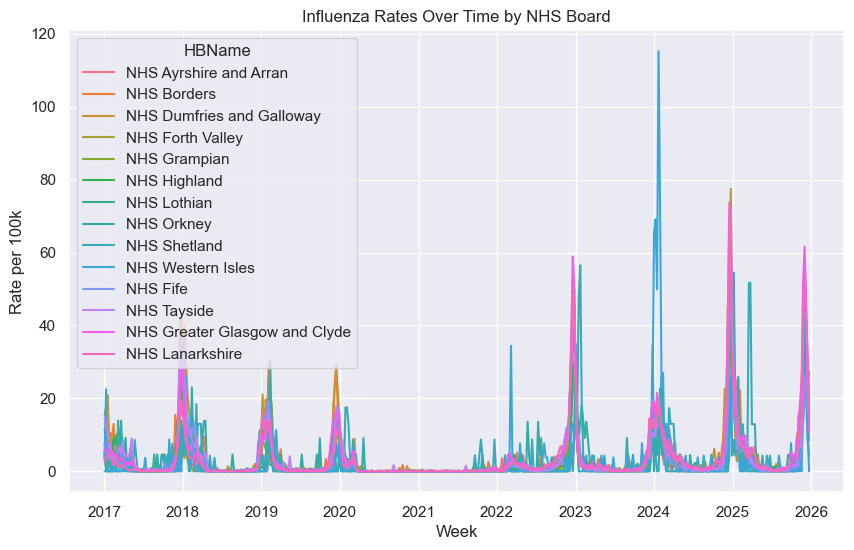

In [34]:
# test visual for flu trends
seasonal_flu_trends = sns.lineplot(data=flu_df, x="WeekBeginning", y="RateCasesPerWeek", hue="HBName")

seasonal_flu_trends.set(
    title="Influenza Rates Over Time by NHS Board",
    ylabel="Rate per 100k",
    xlabel="Week Beginning", 
)
seasonal_flu_trends;

C:\Users\S\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



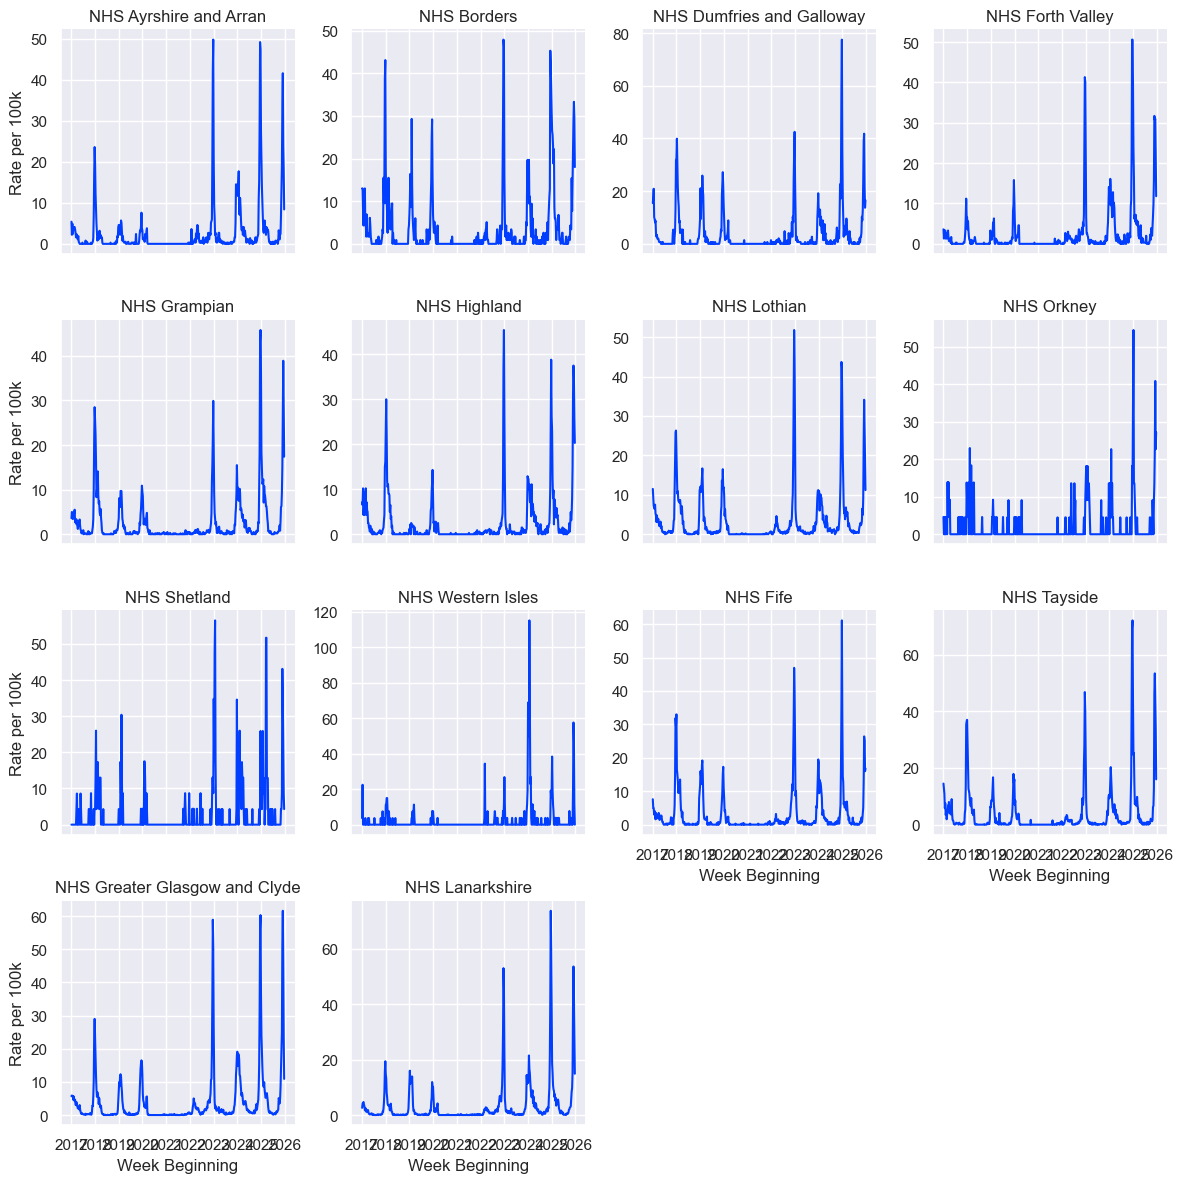

In [93]:
# faceted line plots by NHS Board
nhs_facet = sns.FacetGrid(
    flu_df,
    col="HBName",
    col_wrap=4,
    height=3,
    sharey=False
)

nhs_facet.map_dataframe(
    sns.lineplot,
    x="WeekBeginning",
    y="RateCasesPerWeek"
)

nhs_facet.set_titles("{col_name}")
nhs_facet.set_axis_labels("Week Beginning", "Rate per 100k")
nhs_facet;

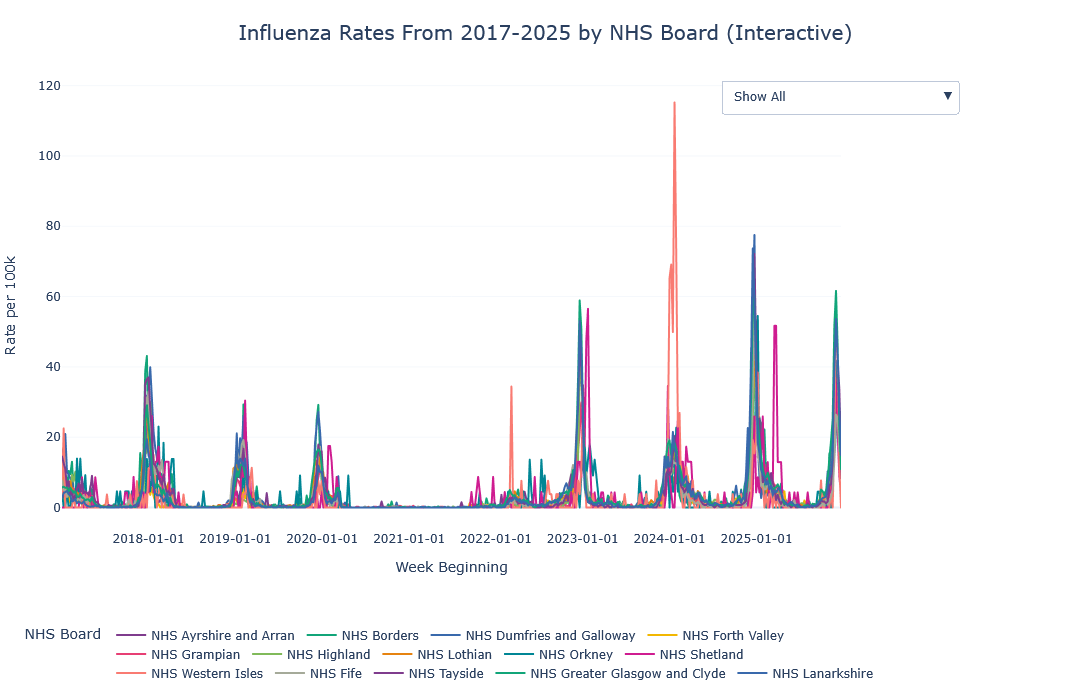

In [88]:
# visualises the influenza rates over time as an interactive plot
flu_time_series = px.line(
    flu_df,
    x="WeekBeginning",
    y="RateCasesPerWeek",
    color="HBName",
    color_discrete_sequence=px.colors.qualitative.Bold,
    title="Influenza Rates From 2017-2025 by NHS Board (Interactive)",
    labels={
        "WeekBeginning": "Week Beginning",
        "RateCasesPerWeek": "Rate per 100k",
        "HBName": "NHS Board"
    },
)

# dropdown filters
flu_time_series.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=[
                dict(
                    label="Show All",
                    method="update",
                    args=[{"visible": [True] * len(flu_time_series.data)}]
                )
            ] + [
                dict(
                    label=board,
                    method="update",
                    args=[{"visible": [trace.name == board for trace in flu_time_series.data]}]
                )
                for board in flu_df["HBName"].unique()
            ],
            direction="down",
            showactive=True,
            x=1.15,
            xanchor="right",
            y=1,
            yanchor="top"
        )
    ]
)


flu_time_series.update_layout(
    template="plotly_white",
    legend=dict(
        title="NHS Board",
        orientation="h",
        yanchor="bottom",
        y=-0.35,
        xanchor="center",
        x=0.5
    ),
    title=dict(
        font=dict(size=20),
        x=0.5
    ),
    width=1200,
    height=700,
    margin=dict(l=60, r=250, t=80, b=60)
)

flu_time_series.update_xaxes(
    tickformat="%Y-%m-%d",
    showgrid=False
)

flu_time_series.update_yaxes(showgrid=True, gridwidth=0.5)

flu_time_series

In [90]:
# export as html
flu_time_series.write_html("influenza_time_series.html")

In [89]:
flu_df["WeekBeginning"].min()

Timestamp('2017-01-02 00:00:00')

<h1>Export</h1>

In [183]:
atlas_qgis_df.head(2)

,small_area,year,total_benefit,h06_se_cod,NHS Board,Local Authority
0,S01006506,2025,1.357863,S08000006,NHS Grampian,Aberdeen City
1,S01006506,2026,2.144043,S08000006,NHS Grampian,Aberdeen City
2,S01006506,2027,2.747846,S08000006,NHS Grampian,Aberdeen City
3,S01006506,2028,3.518102,S08000006,NHS Grampian,Aberdeen City
4,S01006506,2029,4.503312,S08000006,NHS Grampian,Aberdeen City


In [29]:
atlas_qgis_hb_df = atlas_qgis_df.groupby(['h06_se_cod', 'NHS Board', 'year'], as_index=False)['total_benefit'].sum()

In [30]:
atlas_qgis_hb_df.head(2)

,h06_se_cod,NHS Board,year,total_benefit
0,S08000001,NHS Ayrshire and Arran,2025,698.496528
1,S08000001,NHS Ayrshire and Arran,2026,1005.819860
2,S08000001,NHS Ayrshire and Arran,2027,1267.255996
3,S08000001,NHS Ayrshire and Arran,2028,1600.420561
4,S08000001,NHS Ayrshire and Arran,2029,1977.894629
...,...,...,...,...
359,S08000014,NHS Western Isles,2046,996.603545
360,S08000014,NHS Western Isles,2047,996.763831
361,S08000014,NHS Western Isles,2048,990.324324
362,S08000014,NHS Western Isles,2049,982.504692


In [181]:
# final data for the datazones
atlas_qgis_df.to_csv('atlas_qgis.csv', index=False)

In [188]:
# final data for QGIS label displays
atlas_qgis_hb_df.to_csv('atlas_hb_qgis.csv', index=False)

In [217]:
respiratory_hb_df.to_csv('respiratory_hb.csv', index=False)

In [218]:
respiratory_total_rate_hb_df.to_csv('respiratory_total_rate_hb.csv', index=False)